In [1]:
import cv2
import pickle
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import mean_squared_error
%matplotlib inline

['camera_cal/calibration5.jpg', 'camera_cal/calibration4.jpg', 'camera_cal/calibration6.jpg', 'camera_cal/calibration7.jpg', 'camera_cal/calibration3.jpg', 'camera_cal/calibration2.jpg', 'camera_cal/calibration1.jpg', 'camera_cal/calibration20.jpg', 'camera_cal/calibration19.jpg', 'camera_cal/calibration18.jpg', 'camera_cal/calibration15.jpg', 'camera_cal/calibration14.jpg', 'camera_cal/calibration16.jpg', 'camera_cal/calibration17.jpg', 'camera_cal/calibration13.jpg', 'camera_cal/calibration12.jpg', 'camera_cal/calibration10.jpg', 'camera_cal/calibration11.jpg', 'camera_cal/calibration9.jpg', 'camera_cal/calibration8.jpg']


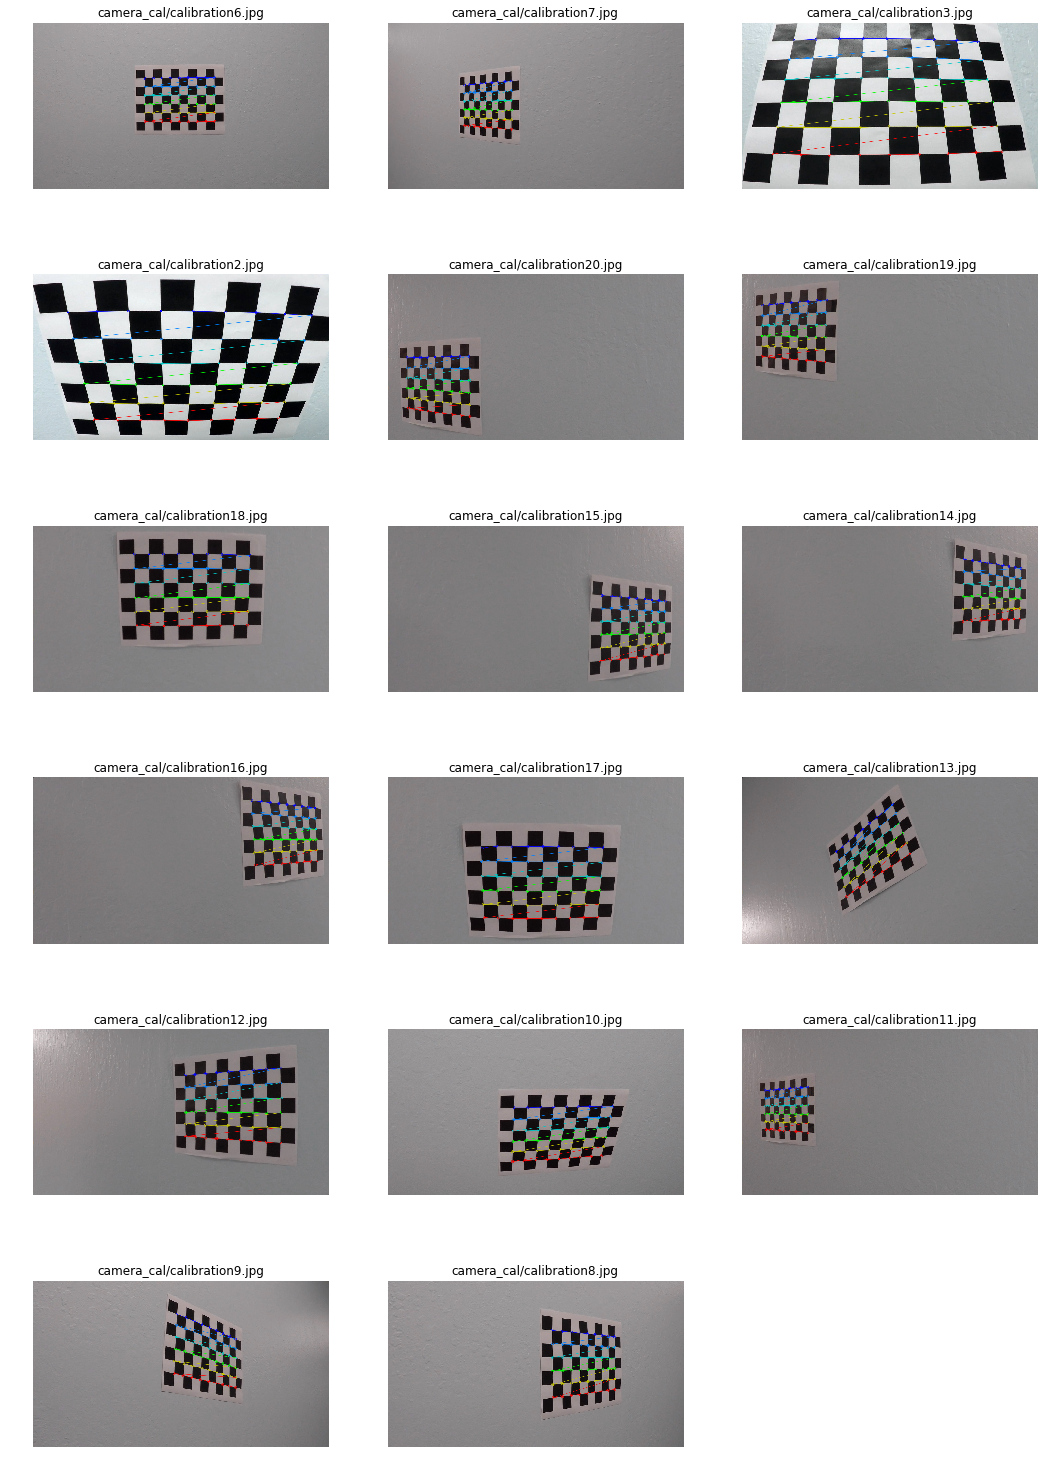

In [2]:
#camera calibration
w = 9
h = 6
objp = np.zeros((w*h,3), np.float32)
objp[:,:2] = np.mgrid[0:w,0:h].T.reshape(-1,2)
objpoints = []
imgpoints = []
images = glob.glob('camera_cal/calibration*.jpg')
print(images)
plt.figure(figsize=(18, 27))
for index, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (w,h), None)
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        plt.subplot(6,3,len(imgpoints))
        cv2.drawChessboardCorners(img,(w,h),corners,ret)
        plt.imshow(img)
        plt.title(fname)
        plt.axis('off')
plt.show() 

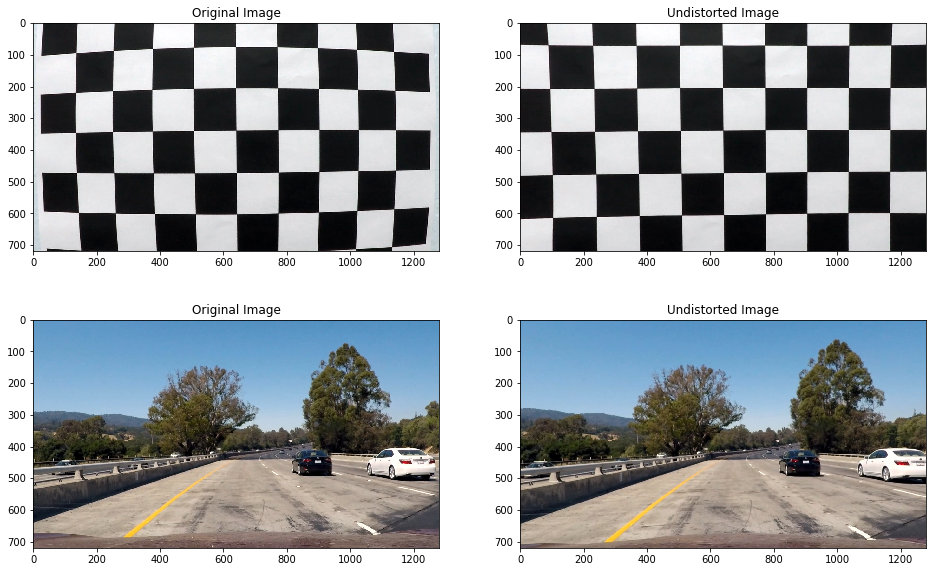

In [3]:
#distortion correction
#test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1],img.shape[0])
#using object points and image points to do calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
def undistortion(img):
    return cv2.undistort(img, mtx, dist,None, mtx)

plt.figure(figsize=(16,10))
plt.subplot(221)
plt.imshow(img)
plt.title('Original Image')

plt.subplot(222)
plt.imshow(undistortion(img))
plt.title('Undistorted Image')

img2 = cv2.imread('test_images/test1.jpg')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.subplot(223)
plt.imshow(img2)
plt.title('Original Image')

plt.subplot(224)
plt.imshow(undistortion(img2))
plt.title('Undistorted Image')
plt.savefig('Read_image/Undistorted.jpg')

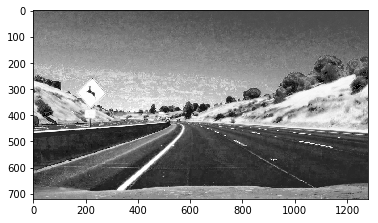

In [4]:
#creating binary image
def his_normalization(img):
    img[:,:,0] = cv2.equalizeHist(img[:,:,0])
    img[:,:,1] = cv2.equalizeHist(img[:,:,1])
    img[:,:,2] = cv2.equalizeHist(img[:,:,2])
    return img
#return saturation channel
def sat_hls(img):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    return hls[:,:,2]

img = cv2.imread('test_images/test2.jpg')
img = his_normalization(img)
img_process = img[:,:,2] + 0.5*sat_hls(img)
img_process = np.uint8(255*img_process/np.max(img_process))
plt.imshow(img_process, cmap = 'gray')
plt.savefig('Read_image/sat_hls_img.jpg')

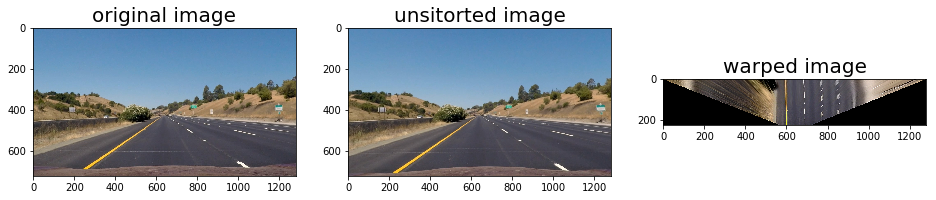

In [5]:
#image transformation
IMAGE_H = 223
IMAGE_W = 1280

#Sharpen image
def sharpen_img(img):
    gb = cv2.GaussianBlur(img, (5,5), 20.0)
    return cv2.addWeighted(img, 2, gb, -1, 0)

#compute linear image transformation
def linear_img(img, s=1.0, m=0.0):
    img2 = cv2.multiply(img, np.array([s]))
    return cv2.add(img2, np.array([m]))

#change image cantrast
def con_img(img, s=1.0):
    m = 127.0*(1.0-s)
    return linear_img(img, s, m)

#creating transformation matrices
def creat_matrice():
    src = np.float32([[0, 673], [1207, 673], [0, 450], [1280, 450]])
    dst = np.float32([[569, 223], [711, 223], [0, 0], [1280, 0]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv

#get the warped image
def transform(img, M):
    undist = undistortion(img)
    img_size = (IMAGE_W, IMAGE_H)
    warped = cv2.warpPerspective(undist, M, img_size, flags = cv2.INTER_LINEAR)
    warped = sharpen_img(warped)
    warped = con_img(warped, 1.1)
    return warped

#show the original and warped image
def show_warped(img, M):
    f, (plot1, plot2, plot3) = plt.subplots(1, 3, figsize=(16,3))   
    plot1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plot1.set_title('original image', fontsize = 20)
    plot2.imshow(cv2.cvtColor(undistortion(img), cv2.COLOR_BGR2RGB))
    plot2.set_title('unsitorted image', fontsize = 20)
    plot3.imshow(cv2.cvtColor(transform(img, M), cv2.COLOR_BGR2RGB))
    plot3.set_title('warped image', fontsize = 20)
def show_img(img):
    if len(img.shape)==3:
        plt.figure()
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        plt.figure()
        plt.imshow(img, cmap = 'gray')
M, Minv = creat_matrice()
for image in glob.glob('test_images/straight_lines1.jpg'):
    img = cv2.imread(image)
    show_warped(img, M)
    plt.savefig('Read_image/warped_img.jpg')

In [6]:
#calculate the coefficients of polynomial(y+h)
def pol_shit(pol, h):
    pol_ord = len(pol) - 1
    if pol_ord == 3:
        pol0 = pol[0]
        pol1 = pol[1] + 3.0*pol[0]*h
        pol2 = pol[2] + 3.0*pol[0]*h*h + 2.0*pol[1]*h
        pol3 = pol[3] + pol[0]*h*h*h + pol[1]*h*h + pol[2]*h
        return np.array([pol0,pol1,pol2,pol3])
    if pol_ord == 2:
        pol0 = pol[0]
        pol1 = pol[1] + 2.0*pol[0]*h
        pol2 = pol[2] + 2.0*pol[0]*h*h + pol[1]*h
        return np.array([pol0,pol1,pol2])
    if pol_ord == 1:
        pol0 = pol[0]
        pol1 = pol[1] + pol[0]*h
        return np.array([pol0,pol1])
    
#calculate the derivative of polynomail(x)
def pol_d(pol, x):
    pol_ord = len(pol) - 1
    if pol_ord == 3:
        return 3.0*pol[0]*x*x + 2.0*pol[1]*x + pol[2]
    if pol_ord == 2:
        return 2.0*pol[0]*x + pol[1]
    if pol_ord ==1:
        return pol[0]

#calculate the second derivate of polynomail(x)
def pol_dd(pol, x):
    pol_ord = len(pol)-1
    if pol_ord == 3:
        return 6.0*pol[0]*x+2.0*pol[1]
    if pol_ord == 2:
        return 2.0*pol[0]
    if pol_ord == 1:
        return 0.0
    
#calculate the value of polynomail(x)
def pol_calc(pol, x):
    pol_f = np.poly1d(pol)
    return pol_f(x)

xm_in_px = 3.675/85
ym_in_px = 3.048/24

#convert offset in pixels in x axis into m
def px_to_m(px): 
    return xm_in_px*px

#calculate the offset from the lane center
def lane_offset(left, right):
    offset = IMAGE_W/2.0 - (pol_calc(left, 1.0) + pol_calc(right, 1.0))/2.0
    return px_to_m(offset)

#calculate the radius of a line
Max_radius = 10000
def  r_curve(pol, y):
    if len(pol) == 2:
        return Max_radius
    else:
        y_pol = np.linspace(0,1,num=EQUID_POINTS)
        x_pol = pol_calc(pol, y_pol)*xm_in_px
        y_pol = y_pol*IMAGE_H*ym_in_px
        pol = np.polyfit(y_pol, x_pol, len(pol)-1)
        d_y = pol_d(pol, y)
        dd_y = pol_dd(pol, y)
        r = ((np.sqrt(1+d_y**2))**3)/abs(dd_y)
        if r > Max_radius:
            r = Max_radius
        return r

#calculate the lane radius by averaging lines curvatures
def lane_curve(left, right):
    l = r_curve(left, 1.0)
    r = r_curve(right, 1.0)
    if l < Max_radius and r < Max_radius:
        return (r_curve(left, 1.0)+r_curve(right, 1.0))/2.0
    else:
        if l < Max_radius:
            return l
        if r < Max_radius:
            return r
        return Max_radius

[ 79.48823117 -37.45752836 627.44035983]


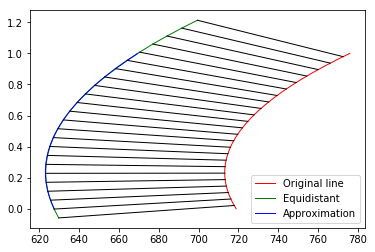

In [7]:
#calculate the equidistant
EQUID_POINTS = 25
def equidistant(pol, d, max_1 = 1, plot=False):
    y_pol = np.linspace(0, max_1, num=EQUID_POINTS)
    x_pol = pol_calc(pol, y_pol)
    y_pol *= IMAGE_H
    x_m = []
    y_m = []
    k_m = []
    for i in range(len(x_pol)-1):
        x_m.append((x_pol[i+1]-x_pol[i])/2.0+x_pol[i])
        y_m.append((y_pol[i+1]-y_pol[i])/2.0+y_pol[i])
        if x_pol[i+1] == x_pol[i]:
            k_m.append(1e8)
        else:
            k_m.append(-(y_pol[i+1]-y_pol[i])/(x_pol[i+1]-x_pol[i]))
    x_m = np.array(x_m)
    y_m = np.array(y_m)
    k_m = np.array(k_m)
    
    #calculate equidistant points
    y_eq = d * np.sqrt(1.0/(1+k_m**2))
    x_eq = np.zeros_like(y_eq)
    if d >= 0:
        for i in range(len(x_m)):
            if k_m[i] < 0:
                y_eq[i] = y_m[i] - abs(y_eq[i])
            else:
                y_eq[i] = y_m[i] + abs(y_eq[i])
            x_eq[i] = (x_m[i]-k_m[i]*y_m[i])+k_m[i]*y_eq[i]
    else:
        for i in range(len(x_m)):
            if k_m[i] < 0:
                y_eq[i] = y_m[i] + abs(y_eq[i])
            else:
                y_eq[i] = y_m[i] - abs(y_eq[i])
            x_eq[i] = (x_m[i]-k_m[i]*y_m[i])+k_m[i]*y_eq[i]
    y_eq /= IMAGE_H
    y_pol /= IMAGE_H
    y_m /= IMAGE_H
    pol_eq = np.polyfit(y_eq, x_eq, len(pol)-1)
    if plot:
        plt.plot(x_pol, y_pol, color = 'red', linewidth = 1, label = 'Original line')
        plt.plot(x_eq, y_eq, color = 'green', linewidth = 1, label ='Equidistant')
        plt.plot(pol_calc(pol_eq, y_pol), y_pol, color = 'blue', linewidth = 1, label = 'Approximation')
        plt.legend()
        for i in range(len(x_m)):
            plt.plot([x_m[i], x_eq[i]], [y_m[i], y_eq[i]], color = 'black', linewidth=1)
        plt.savefig('Read_image/equidistant.jpg')
    return pol_eq

pol = np.array([106.65796008,  -49.57665396,  718.87055435])
print(equidistant(pol, -90, plot=True))

In [8]:
#choose the best polynomail order
DEV_POL = 2
MSE_DEV = 1.1
def best_pol_ord(x, y):
    pol1 = np.polyfit(y,x,1)
    pred1 = pol_calc(pol1, y)
    mse1 = mean_squared_error(x, pred1)
    if mse1 < DEV_POL:
        return pol1, mse1
    pol2 = np.polyfit(y,x,2)
    pred2 = pol_calc(pol2, y)
    mse2 = mean_squared_error(x, pred2)
    if mse2 < DEV_POL or mse1/mse2 < MSE_DEV:
        return pol2, mse2
    else:
        pol3 = np.polyfit(y,x,3)
        pred3 = pol_calc(pol3, y)
        mse3 = mean_squared_error(x, pred3)
        if mse3/mse2 < MSE_DEV:
            return pol2, mse2
        else:
            return pol3, mse3
        
#smooth polinomial function
def smooth_dif_ord(pol_p, x, y, new_ord):
    x_p = pol_calc(pol_p, y)
    x_new = (x+x_p)/2.0
    return np.polyfit(y, x_new, new_ord)

In [9]:
#calculate the threshold for line sides
def thres_left_calc(sens):
    thres = -0.0045*sens**2+1.7581*sens-115.0
    if thres < 25*(382.0-sens)/382.0+5:
        thres = 25*(382.0-sens)/382.0+5
    return thres

def thres_right_calc(sens):
    thres = -0.0411*sens**2+9.1708*sens-430.0
    if sens < 210:
        if thres < sens/6:
            thres = sens/6
    else:
        if thres < 20:
            thres = 20
    return thres

In [10]:
#creat virtual sensors
WINDOW_SIZE = 15
DEV = 7
SPEED = 2/IMAGE_H
POL_ORD = 2
RANGE = 0.0

def find(img, left = True, p_ord = POL_ORD, pol = np.zeros(POL_ORD+1), max_n = 0):
    x_pos = []
    y_pos = []
    max_l = img.shape[0]
    for i in range(max_l-int(max_l*RANGE)):
        y = max_l-i
        y_01 = y/float(max_l)
        if abs(pol[-1]) > 0:
            if y_01 >= max_n + SPEED:
                cent = int(pol_calc(pol, y_01-SPEED))
                if y == max_l:
                    if left:
                        cent = 605
                    else:
                        cent = 690
            else:
                k = pol_d(pol, max_n)
                b = pol_calc(pol, max_n)-k*max_n
                cent = int(k*y_01+b)
            if cent > IMAGE_W-WINDOW_SIZE:
                cent = IMAGE_W-WINDOW_SIZE
            if cent < WINDOW_SIZE:
                cent = WINDOW_SIZE
        else:
            if len(x_pos) > 0:
                cent = x_pos[-1]
            else:
                if left:
                    cent  = 605
                else:
                    cent = 690
        if left:
            sens = 0.5*sat_hls(img[max_l-1-i:max_l-i, cent-WINDOW_SIZE:cent+WINDOW_SIZE, :]) \
            +img[max_l-1-i:max_l-i,cent-WINDOW_SIZE:cent+WINDOW_SIZE,2]
        else:
            sens = img[max_l-1-i:max_l-i,cent-WINDOW_SIZE:cent+WINDOW_SIZE,2]
        if len(sens[0,:]) < WINDOW_SIZE:
            break
        x_max = max(sens[0,:])
        sens_mean = np.mean(sens[0,:])
        
        # get the threshold
        if left:
            loc_thres = thres_left_calc(sens_mean)
            loc_dev = DEV
        else:
            loc_thres = thres_right_calc(sens_mean)
            loc_dev = DEV
        if len(x_pos) == 0:
            loc_dev = WINDOW_SIZE
        if x_max-sens_mean > loc_thres and x_max > 100 or left:
            if left:
                x = list(reversed(sens[0,:])).index(x_max)
                x = cent + WINDOW_SIZE - x
            else:
                x = list(sens[0,:]).index(x_max)
                x = cent - WINDOW_SIZE + x
            if x-1 < 569.0*y_01 or x+1 > 569.0*y_01+711 or len(np.nonzero(sens[0,:])[0]) < WINDOW_SIZE:
                break 
            if abs(pol[-1]) < 0.0001:    
                x_pos.append(x)
                y_pos.append(y_01)
            else:
                if abs(x-cent) < loc_dev: 
                    x_pos.append(x)
                    y_pos.append(y_01)
    if len(x_pos) > 1:
        return x_pos, y_pos
    else:
        return [0], [0.0]

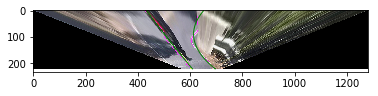

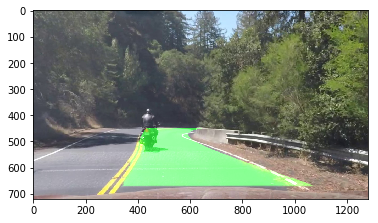

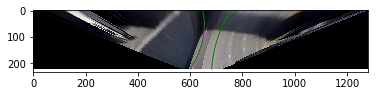

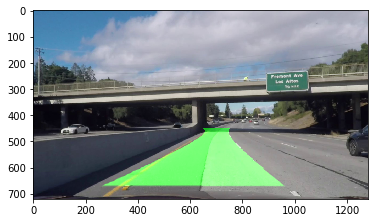

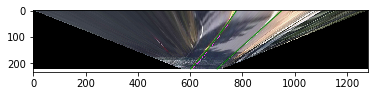

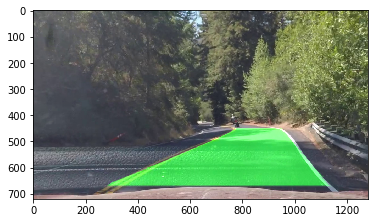

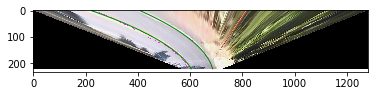

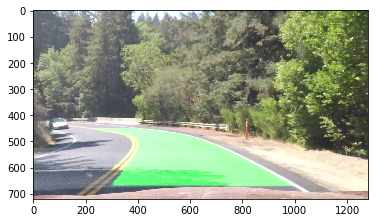

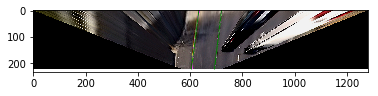

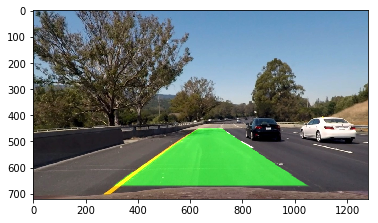

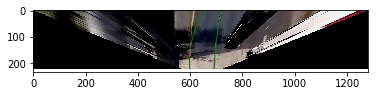

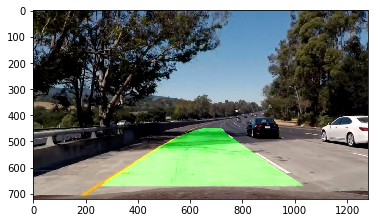

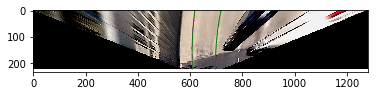

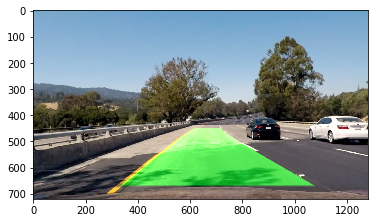

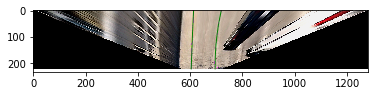

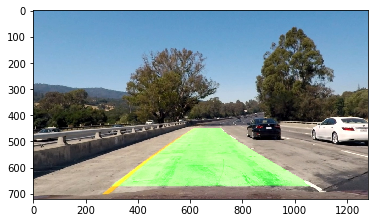

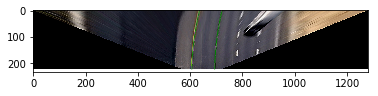

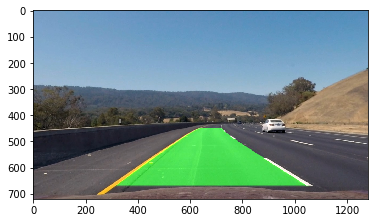

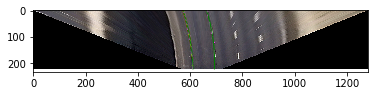

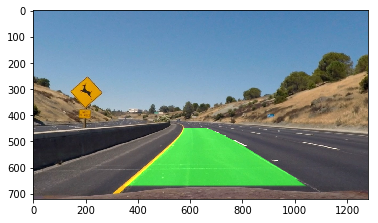

In [11]:
#draw a line on image
RANGE = 0.0
def get_lane(img, plot=False):
    warp = transform(img, M)
    img = undistortion(img)
    ploty = np.linspace(0, 1, num=warp.shape[0])
    x2, y2 = find(warp)
    x, y = find(warp, False)
    right_fitx = pol_calc(best_pol_ord(x,y)[0], ploty)
    left_fitx = pol_calc(best_pol_ord(x2,y2)[0], ploty)
    y2 = np.int16(np.array(y2)*233.0)
    y = np.int16(np.array(y)*223.0)
    if plot:
        for i in range(len(x)):
            cv2.circle(warp, (x[i], y[i]), 1, (255,50,255))
        for i in range(len(x2)):
            cv2.circle(warp, (x2[i], y2[i]), 1, (255,50,250))
        show_img(warp)
        #plot.axis('off')
        plt.plot(left_fitx, ploty*IMAGE_H, color = 'green', linewidth=1)
        plt.plot(right_fitx, ploty*IMAGE_H, color = 'green', linewidth=1)
        cv2.imwrite('img.jpg', warp)
    return img, left_fitx, right_fitx, ploty*IMAGE_H

def draw_lane_img_p(img_path):
    return cv2.imread(img_path)

def draw_lane(img, video = False):
    if video:
        img, left_fitx, right_fitx, ploty, left, right = get_lane_video(img)
    else:
        img, left_fitx, right_fitx, ploty = get_lane(img, True)
    warp_zero = np.zeros((IMAGE_H,IMAGE_W)).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255,0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]))
    
    result = cv2.addWeighted(img, 1.0, newwarp, 0.6, 0)
    if video:
        font = cv2.FONT_HERSHEY_SIMPLEX
        text_pos = 'Pos of the car: ' + str(np.round(lane_offset(left, right), 2)) + 'm'
        radius = np.round(lane_curve(left, right), 2)
        if radius >= Max_radius:
            radius = 'Inf'
        else:
            radius = str(radius)
        text_rad = 'Radius: ' + radius + ' m'
        cv2.putText(result, text_pos, (10,25), font, 1, (255,255,255) ,2)
        cv2.putText(result, text_pos, (10,75), font, 1, (255,255,255) ,2)
        return(result)
    else:
        show_img(result)
        plt.savefig("Read_image/LineFinding.jpg")
        
for image in glob.glob('test_images/test*.jpg'):
    draw_lane(draw_lane_img_p(image))

In [12]:
#draw a lane on video
right_fit_ori = np.zeros(POL_ORD + 1)
left_fit_ori = np.zeros(POL_ORD + 1)
Min_line = 60
Max_line = 95
Min_points = 10
Max_frame = 5
count = 0
right_fail, left_fail = 0, 0
right_length, left_length = 0, 0

def get_lane_video(img):
    global right_fit_ori, left_fit_ori, right_length, left_length, count, right_fail, left_fail
    sw = False
    warp = transform(img, M)
    img = undistortion(img)
    if left_length < Max_frame and count > 0:
        x, y = find(warp, pol = left_fit_ori, max_n = left_length)
    else:
        x, y = find(warp)
    if len(x) > Min_points:
        left_fit, mse_left = best_pol_ord(x,y)
        if mse_left > DEV_POL * 9 and count > 0:
            left_fit = left_fit_ori
            left_fail += 1
        else:
            left_fail /= 2
    else:
        left_fit = left_fit_ori
        left_fail += 1
    if right_fail < Max_frame and count > 0:
        x2, y2 = find(warp, False, pol = right_fit_ori, max_n = right_length)
    else:
        x2, y2 = find(warp, False)
    if len(x2) > Min_points:
        right_fit , mse_right = best_pol_ord(x2, y2)
        if mse_right >DEV_POL * 9 and count > 0:
            right_fit = right_fit_ori
            right_fail += 1
        else:
            right_fail /= 2
    else:
        right_fit = right_fit_ori
        right_fail += 1
    
    if count > 0: #  if this is not the first video frame
        if len(left_fit_ori) == len(left_fit):
            left_fit = pol_shit(left_fit_ori, -SPEED) * ((1.0-len(x)/(1.0-RANGE)*IMAGE_H)) + left_fit * (len(x)/((1.0-RANGE)*IMAGE_H))
        else:
            left_fit = smooth_dif_ord(left_fit_ori, x, y, len(left_fit)-1)
        left_length = y[-1]
        if len(right_fit_ori) == len(right_fit):
            right_fit = pol_shit(right_fit_ori, -SPEED) * ((1.0-len(x)/(1.0-RANGE)*IMAGE_H)) + right_fit * (len(x2)/((1.0-RANGE)*IMAGE_H))
        else:
            right_fit = smooth_dif_ord(right_fit_ori, x2, y2, len(right_fit)-1)
        right_length = y2[-1]
        
    #when only get the left line:
    if len(x) > Min_points and len(x2) <= Min_points:
        lane_w = pol_calc(right_fit_ori, 1.0) - pol_calc(left_fit_ori, 1.0)
        right_fit = smooth_dif_ord(right_fit_ori, pol_calc(equidistant(left_fit, lane_w, max_1 = left_length), y), y, len(left_fit)-1)
        right_length = left_length
        right_fail /= 2
    #when only get the right line
    if len(x2) > Min_points and len(x) <= Min_points:
        lane_w = pol_calc(right_fit_ori, 1.0) - pol_calc(left_fit_ori, 1.0)
        left_fit = smooth_dif_ord(left_fit_ori, pol_calc(equidistant(right_fit, lane_w, max_1 = right_length), y), y, len(right_fit)-1)
        left_length = right_length
        left_fail /= 2
    if left_fail < Max_frame and right_fail < Max_frame:
        max_y = max(RANGE, left_length, right_length)
    else:
        max_y = 1.0
        sw = False
        
    d1 = pol_calc(right_fit, 1.0) - pol_calc(left_fit, 1.0)
    dm = pol_calc(right_fit, max_y) - pol_calc(left_fit, max_y)
    if d1 > Max_line or d1 < 60 or dm < 0:
        left_fit = left_fit_ori
        right_fit = right_fit_ori
        left_fail = 0
        right_fail = 0
    ploty = np.linspace(max_y, 1, num = IMAGE_H)
    left_fitx = pol_calc(left_fit, ploty)
    right_fitx = pol_calc(right_fit, ploty)
    right_fit_ori = np.copy(right_fit)
    left_fit_ori = np.copy(left_fit)
    count += 1
    return img, left_fitx, right_fitx, ploty*223.0, left_fit, right_fit

In [13]:
# making real_video processing
from moviepy.editor import VideoFileClip

def init_parameters(ran):
    global right_fit_ori, left_fit_ori, count, RANGE, Min_points
    right_fit_ori = np.zeros(POL_ORD + 1)
    left_fit_ori = np.zeros(POL_ORD + 1)
    count = 0
    RANGE = ran
    Min_points = 25-15*ran
def process_image(image):
    return draw_lane(image, True)

init_parameters(0.0)
output = 'ee551project_video_proc.mp4'
clip1 = VideoFileClip('ee551project_video.mp4')
clip = clip1.fl_image(process_image)
%time clip.write_videofile(output, audio = False)

[MoviePy] >>>> Building video ee551project_video_proc.mp4
[MoviePy] Writing video ee551project_video_proc.mp4


100%|█████████▉| 744/745 [00:51<00:00, 16.18it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ee551project_video_proc.mp4 

CPU times: user 3min 20s, sys: 7.63 s, total: 3min 27s
Wall time: 52 s
